# Clasificación de gestos de mano mediante señales EMG utilizando redes LSTM

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import os
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
datasetPath = "/content/drive/MyDrive/ConcentracionIA/Periodo2/Mod2. Tecnicas y arquitecturas de deep learning/Proyecto/PortafolioImplementacionMod2/Dataset"
modelPath = "/content/drive/MyDrive/ConcentracionIA/Periodo2/Mod2. Tecnicas y arquitecturas de deep learning/Proyecto/PortafolioImplementacionMod2/Modelo/EMGLSTMModel.pt"
scalerPath = "/content/drive/MyDrive/ConcentracionIA/Periodo2/Mod2. Tecnicas y arquitecturas de deep learning/Proyecto/PortafolioImplementacionMod2/Scaler/scaler.save"

txtFiles = sorted(glob.glob(os.path.join(datasetPath, "**/*.txt"), recursive=True))
print(f"Archivos encontrados: {len(txtFiles)}")

Archivos encontrados: 82


In [9]:
def loadFile(filePath):
    try:
        dfRaw = pd.read_csv(
            filePath,
            sep=r"\s+",
            engine="python",
            header=None,
            on_bad_lines='skip'
        )

        if dfRaw.shape[1] != 10:
            print(f"Archivo con columnas inesperadas: {filePath} : {dfRaw.shape[1]} columnas")
            return pd.DataFrame()

        dfRaw.columns = ['time'] + [f'ch{i}' for i in range(1, 9)] + ['label']
        dfRaw = dfRaw[dfRaw['label'] != 0]
        return dfRaw

    except Exception as e:
        print(f"Error al leer {filePath}: {e}")
        return pd.DataFrame()


allDataDf = pd.concat([loadFile(f) for f in txtFiles], ignore_index=True)
print(allDataDf.head())
print(allDataDf['label'].value_counts())

Archivo con columnas inesperadas: /content/drive/MyDrive/ConcentracionIA/Periodo2/Mod2. Tecnicas y arquitecturas de deep learning/Proyecto/PortafolioImplementacionMod2/Dataset/README.txt : 3 columnas
   time       ch1       ch2       ch3       ch4       ch5       ch6       ch7  \
0  time  channel1  channel2  channel3  channel4  channel5  channel6  channel7   
1     1     1e-05    -2e-05    -1e-05    -3e-05         0    -1e-05         0   
2     5     1e-05    -2e-05    -1e-05    -3e-05         0    -1e-05         0   
3     6    -1e-05     1e-05     2e-05         0     1e-05    -2e-05    -1e-05   
4     7    -1e-05     1e-05     2e-05         0     1e-05    -2e-05    -1e-05   

        ch8  label  
0  channel8  class  
1    -1e-05      0  
2    -1e-05      0  
3     1e-05      0  
4     1e-05      0  
label
0        3083237
6         282646
5         282008
1         280847
4         280543
3         279131
2         272798
7          17125
class         81
Name: count, dtype: int64


In [10]:
allDataDf = allDataDf.apply(pd.to_numeric, errors='coerce')
allDataDf = allDataDf.dropna().reset_index(drop=True)

print("Shape después de limpiar filas no numéricas:", allDataDf.shape)

Shape después de limpiar filas no numéricas: (4778335, 10)


In [11]:
dfChannels = [f'ch{i}' for i in range(1, 9)]

scaler = StandardScaler()
allDataDf[dfChannels] = scaler.fit_transform(allDataDf[dfChannels])

print(allDataDf[dfChannels].describe().T[['mean', 'std']])

             mean  std
ch1 -3.574770e-17  1.0
ch2  6.548416e-17  1.0
ch3  5.701193e-17  1.0
ch4 -1.475931e-17  1.0
ch5 -2.667992e-17  1.0
ch6 -2.399884e-17  1.0
ch7 -9.445481e-18  1.0
ch8 -3.703991e-17  1.0


In [12]:

def createSlidingWindows(dataframe, channels, windowSize=200, stepSize=100):
    x, y = [], []
    dataArray = dataframe[channels + ['label']].values
    totalLen = len(dataArray)

    for start in range(0, totalLen - windowSize, stepSize):
        end = start + windowSize
        window = dataArray[start:end]
        segment = window[:, :-1]
        labels = window[:, -1]

        if np.all(labels == labels[0]):
            x.append(segment)
            y.append(int(labels[0]))

    return np.array(x), np.array(y)

In [13]:
windowSize = 200
stepSize = 100

xData, yData = createSlidingWindows(allDataDf, dfChannels, windowSize, stepSize)

print("X shape:", xData.shape)
print("y shape:", yData.shape)
print("Clases disponibles:", np.unique(yData, return_counts=True))

X shape: (43878, 200, 8)
y shape: (43878,)
Clases disponibles: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([28869,  2490,  2405,  2473,  2486,  2492,  2511,   152]))


In [14]:
# Train (80%) y test/val (20%)
xTrain, xTestVal, yTrain, yTestVal = train_test_split(
    xData, yData, test_size=0.2, stratify=yData, random_state=42
)

# De test/val (20%), sacamos val (10%) y test (10%)
xVal, xTest, yVal, yTest = train_test_split(
    xTestVal, yTestVal, test_size=0.5, stratify=yTestVal, random_state=42
)

print("Train:", xTrain.shape, yTrain.shape)
print("Val:", xVal.shape, yVal.shape)
print("Test:", xTest.shape, yTest.shape)

Train: (35102, 200, 8) (35102,)
Val: (4388, 200, 8) (4388,)
Test: (4388, 200, 8) (4388,)


In [15]:
class EMGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
batchSize = 64

dfTrain = EMGDataset(xTrain, yTrain)
dfVal   = EMGDataset(xVal, yVal)
dfTest  = EMGDataset(xTest, yTest)

loaderTrain = DataLoader(dfTrain, batch_size=batchSize, shuffle=True)
loaderVal  = DataLoader(dfVal, batch_size=batchSize, shuffle=False)
loaderTest  = DataLoader(dfTest, batch_size=batchSize, shuffle=False)

In [17]:
class EMGLSTMClassifier(nn.Module):
    def __init__(self, inputSize=8, latentDim=64, layers=1, classes=8, dropout=0.3):
        super(EMGLSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(input_size=inputSize,
                            hidden_size=latentDim,
                            num_layers=layers,
                            batch_first=True,
                            dropout=dropout)

        self.fc1 = nn.Linear(latentDim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

model = EMGLSTMClassifier(inputSize=8, classes=8).to(device)

Usando dispositivo: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [19]:
epochs = 30
learningRate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)

def evaluate(model, dataLoader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for xBatch, yBatch in dataLoader:
            xBatch, yBatch = xBatch.to(device), yBatch.to(device)
            outputs = model(xBatch)
            _, predicted = torch.max(outputs.data, 1)
            total += yBatch.size(0)
            correct += (predicted == yBatch).sum().item()

    return 100 * correct / total

In [20]:
lossesTrain = []
accuraciesVal = []

for epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    progressBar = tqdm(loaderTrain, desc=f"Época {epoch+1}/{epochs}")

    for xBatch, yBatch in progressBar:
        xBatch, yBatch = xBatch.to(device), yBatch.to(device)
        optimizer.zero_grad()
        outputs = model(xBatch)
        loss = criterion(outputs, yBatch)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        progressBar.set_postfix(loss=loss.item())

    avg_loss = runningLoss / len(loaderTrain)
    val_acc = evaluate(model, loaderVal)
    lossesTrain.append(avg_loss)
    accuraciesVal.append(val_acc)

    print(f"=> Época {epoch+1}: Loss={avg_loss:.4f} | Val Acc={val_acc:.2f}%")

Época 1/30: 100%|██████████| 549/549 [00:03<00:00, 138.60it/s, loss=0.936]


=> Época 1: Loss=1.0815 | Val Acc=64.95%


Época 2/30: 100%|██████████| 549/549 [00:02<00:00, 223.84it/s, loss=0.951]


=> Época 2: Loss=0.9499 | Val Acc=66.50%


Época 3/30: 100%|██████████| 549/549 [00:02<00:00, 214.95it/s, loss=1.14]


=> Época 3: Loss=0.8998 | Val Acc=65.93%


Época 4/30: 100%|██████████| 549/549 [00:03<00:00, 180.74it/s, loss=0.786]


=> Época 4: Loss=0.8186 | Val Acc=66.93%


Época 5/30: 100%|██████████| 549/549 [00:02<00:00, 226.17it/s, loss=0.807]


=> Época 5: Loss=0.7810 | Val Acc=66.77%


Época 6/30: 100%|██████████| 549/549 [00:02<00:00, 221.46it/s, loss=0.787]


=> Época 6: Loss=0.7610 | Val Acc=66.20%


Época 7/30: 100%|██████████| 549/549 [00:02<00:00, 224.00it/s, loss=0.765]


=> Época 7: Loss=0.7402 | Val Acc=66.57%


Época 8/30: 100%|██████████| 549/549 [00:02<00:00, 218.61it/s, loss=0.811]


=> Época 8: Loss=0.7283 | Val Acc=67.75%


Época 9/30: 100%|██████████| 549/549 [00:02<00:00, 186.37it/s, loss=0.644]


=> Época 9: Loss=0.7139 | Val Acc=68.39%


Época 10/30: 100%|██████████| 549/549 [00:02<00:00, 219.13it/s, loss=0.563]


=> Época 10: Loss=0.7083 | Val Acc=67.07%


Época 11/30: 100%|██████████| 549/549 [00:02<00:00, 220.22it/s, loss=0.608]


=> Época 11: Loss=0.7053 | Val Acc=67.14%


Época 12/30: 100%|██████████| 549/549 [00:02<00:00, 220.52it/s, loss=0.745]


=> Época 12: Loss=0.6997 | Val Acc=67.73%


Época 13/30: 100%|██████████| 549/549 [00:02<00:00, 215.08it/s, loss=0.974]


=> Época 13: Loss=0.6961 | Val Acc=68.00%


Época 14/30: 100%|██████████| 549/549 [00:02<00:00, 187.54it/s, loss=0.626]


=> Época 14: Loss=0.6965 | Val Acc=67.96%


Época 15/30: 100%|██████████| 549/549 [00:02<00:00, 213.03it/s, loss=0.893]


=> Época 15: Loss=0.6918 | Val Acc=68.62%


Época 16/30: 100%|██████████| 549/549 [00:02<00:00, 218.36it/s, loss=0.637]


=> Época 16: Loss=0.6836 | Val Acc=66.39%


Época 17/30: 100%|██████████| 549/549 [00:02<00:00, 216.23it/s, loss=0.596]


=> Época 17: Loss=0.6738 | Val Acc=68.76%


Época 18/30: 100%|██████████| 549/549 [00:02<00:00, 221.03it/s, loss=0.498]


=> Época 18: Loss=0.6697 | Val Acc=69.07%


Época 19/30: 100%|██████████| 549/549 [00:03<00:00, 182.53it/s, loss=0.697]


=> Época 19: Loss=0.6676 | Val Acc=68.00%


Época 20/30: 100%|██████████| 549/549 [00:02<00:00, 203.96it/s, loss=0.554]


=> Época 20: Loss=0.6621 | Val Acc=68.57%


Época 21/30: 100%|██████████| 549/549 [00:02<00:00, 214.82it/s, loss=0.696]


=> Época 21: Loss=0.6582 | Val Acc=68.85%


Época 22/30: 100%|██████████| 549/549 [00:02<00:00, 214.33it/s, loss=0.875]


=> Época 22: Loss=0.6569 | Val Acc=68.89%


Época 23/30: 100%|██████████| 549/549 [00:02<00:00, 211.19it/s, loss=0.706]


=> Época 23: Loss=0.6586 | Val Acc=68.00%


Época 24/30: 100%|██████████| 549/549 [00:03<00:00, 182.92it/s, loss=0.842]


=> Época 24: Loss=0.6762 | Val Acc=67.68%


Época 25/30: 100%|██████████| 549/549 [00:02<00:00, 207.20it/s, loss=0.702]


=> Época 25: Loss=0.6679 | Val Acc=68.00%


Época 26/30: 100%|██████████| 549/549 [00:02<00:00, 216.06it/s, loss=0.63]


=> Época 26: Loss=0.6599 | Val Acc=67.57%


Época 27/30: 100%|██████████| 549/549 [00:02<00:00, 212.44it/s, loss=0.515]


=> Época 27: Loss=0.6432 | Val Acc=69.17%


Época 28/30: 100%|██████████| 549/549 [00:02<00:00, 208.49it/s, loss=0.824]


=> Época 28: Loss=0.6445 | Val Acc=67.71%


Época 29/30: 100%|██████████| 549/549 [00:02<00:00, 196.57it/s, loss=0.402]


=> Época 29: Loss=0.6426 | Val Acc=68.57%


Época 30/30: 100%|██████████| 549/549 [00:02<00:00, 198.48it/s, loss=0.772]


=> Época 30: Loss=0.6542 | Val Acc=68.12%


In [21]:
def getAllPreds(model, dataLoader):
    model.eval()
    yTrue, yPred = [], []

    with torch.no_grad():
        for xBatch, yBatch in dataLoader:
            xBatch = xBatch.to(device)
            outputs = model(xBatch)
            _, predicted = torch.max(outputs.data, 1)

            yTrue.extend(yBatch.cpu().numpy())
            yPred.extend(predicted.cpu().numpy())

    return np.array(yTrue), np.array(yPred)

yTrueTest, yPredTest = getAllPreds(model, loaderTest)

accuracyTest = np.mean(yTrueTest == yPredTest) * 100
print(f"Accuracy en test set: {accuracyTest:.2f}%")

Accuracy en test set: 68.03%


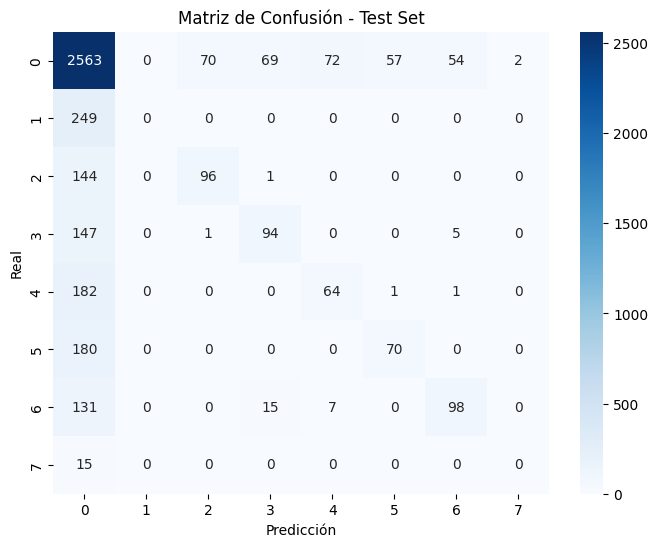

In [22]:
cm = confusion_matrix(yTrueTest, yPredTest)
labels = np.unique(yData)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Test Set')
plt.show()

In [23]:
print("Reporte de clasificación:")
print(classification_report(yTrueTest, yPredTest, digits=4))

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7098    0.8878    0.7889      2887
           1     0.0000    0.0000    0.0000       249
           2     0.5749    0.3983    0.4706       241
           3     0.5251    0.3806    0.4413       247
           4     0.4476    0.2581    0.3274       248
           5     0.5469    0.2800    0.3704       250
           6     0.6203    0.3904    0.4792       251
           7     0.0000    0.0000    0.0000        15

    accuracy                         0.6803      4388
   macro avg     0.4281    0.3244    0.3597      4388
weighted avg     0.6200    0.6803    0.6367      4388



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
torch.save(model.state_dict(), modelPath)
joblib.dump(scaler, scalerPath)
np.savez("training_curves.npz",
         lossesTrain=np.array(lossesTrain),
         accuraciesVal=np.array(accuraciesVal),
         accuracyTest=np.array([accuracyTest]))

print("Modelo guardado en:", modelPath)
print("Scaler guardado en:", scalerPath)
print("Curvas de entrenamiento guardadas en training_curves.npz")

Modelo guardado en: /content/drive/MyDrive/ConcentracionIA/Periodo2/Mod2. Tecnicas y arquitecturas de deep learning/Proyecto/PortafolioImplementacionMod2/Modelo/EMGLSTMModel.pt
Scaler guardado en: /content/drive/MyDrive/ConcentracionIA/Periodo2/Mod2. Tecnicas y arquitecturas de deep learning/Proyecto/PortafolioImplementacionMod2/Scaler/scaler.save
Curvas de entrenamiento guardadas en training_curves.npz


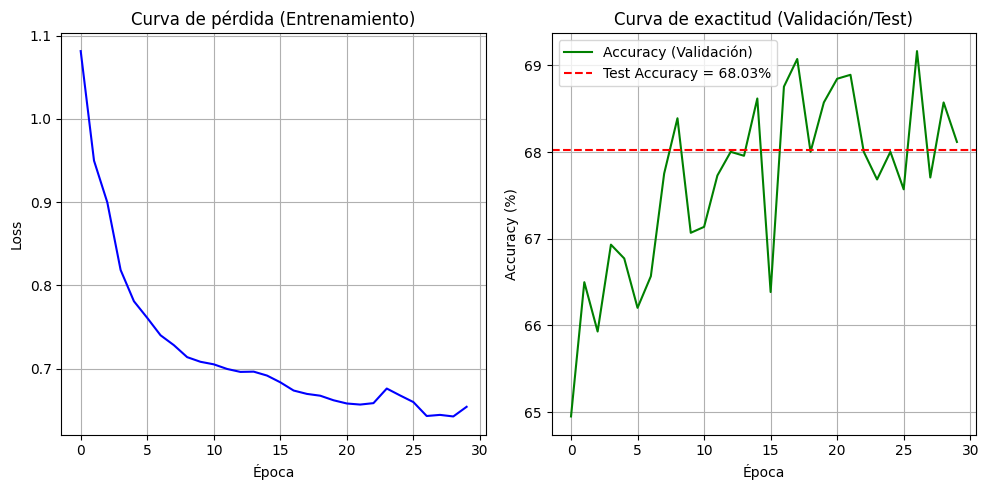

In [25]:
data = np.load("training_curves.npz", allow_pickle=True)
lossesTrain = data["lossesTrain"]
accuraciesVal = data["accuraciesVal"]
accuracyTest = data["accuracyTest"][0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(lossesTrain, label="Loss (Train)", color="blue")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curva de pérdida (Entrenamiento)")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(accuraciesVal, label="Accuracy (Validación)", color="green")
plt.axhline(y=accuracyTest, color="red", linestyle="--",
            label=f"Test Accuracy = {accuracyTest:.2f}%")
plt.xlabel("Época")
plt.ylabel("Accuracy (%)")
plt.title("Curva de exactitud (Validación/Test)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()